Here:
- generate time series (cont OU process?)
- plot it (continious and also binned)
- calculate acf: using ABC tau, using py functions
- plot acf

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # comment this line if you don't want to use seaborn for plots

import numpy as np
# IP import warnings because of "module 'numpy' has no attribute 'warnings'"
import warnings
np.warnings = warnings
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
from scipy import stats

import quantities as pq
from elephant.spike_train_correlation import spike_time_tiling_coefficient
import neo

# add the path to the abcTau package
import sys
#sys.path.append('./abcTau')
sys.path.append('C:\\Users\\ipochino\\.conda\\envs\\isttc\\Lib\\site-packages\\abcTau') # IP: replaced previous line with that; relative path was not working
import abcTau

In [2]:
def func_exp(x, a, b, c):
    """
    Exponential function to fit the data.
    :param x: 1d array, independent variable
    :param a: float, parameter to fit
    :param b: float, parameter to fit
    :param c: float, parameter to fit
    :return: callable
    """
    return a * np.exp(-b * x) + c

In [3]:
def calculate_acf_isttc(spike_train_ms_int_l_, n_lags_, resolution_ms_):
    """
    Calculate ACF using iSTTC autocorrelation.

    :param spike_train_ms_int_l_:
    :param n_lags_: int, number of time lags to calculate ACF on
    :param resolution_ms_: int, shift step
    :return:
    """
    shift_ms_l = np.linspace(resolution_ms_+1, resolution_ms_ * n_lags_ + 1, n_lags_).astype(int)
    spike_train_bin = np.zeros(spike_train_ms_int_l_[-1] + 1)
    spike_train_bin[spike_train_ms_int_l_] = 1

    sttc_self_l = []

    # correlate with itself
    spike_train_neo = neo.SpikeTrain(spike_train_ms_int_l_, units='ms', t_start=0, t_stop=len(spike_train_bin))
    sttc_no_shift = spike_time_tiling_coefficient(spike_train_neo, spike_train_neo, dt=resolution_ms_ * pq.ms)
    sttc_self_l.append(sttc_no_shift)

    # correlated shifted signal
    for shift_ms in shift_ms_l:
        spike_train_bin1 = spike_train_bin[:-1 - shift_ms + 1]
        spike_train_bin2 = spike_train_bin[shift_ms:]

        spike_train_bin1_idx = np.nonzero(spike_train_bin1)[0]
        spike_train_bin2_idx = np.nonzero(spike_train_bin2)[0]

        spike_train_neo_1 = neo.SpikeTrain(spike_train_bin1_idx, units='ms', t_start=0, t_stop=len(spike_train_bin1))
        spike_train_neo_2 = neo.SpikeTrain(spike_train_bin2_idx, units='ms', t_start=0, t_stop=len(spike_train_bin2))

        sttc_self = spike_time_tiling_coefficient(spike_train_neo_1, spike_train_neo_2, dt=resolution_ms_ * pq.ms)
        sttc_self_l.append(sttc_self)

    acf_not_binned = np.asarray(sttc_self_l)
    return acf_not_binned

### Generate time series

In [4]:
tau = np.array([100])
D = 1/tau
deltaT = 1
T = 1000
numTrials = 1

data_mean = 0.5 # average of firing rate
data_var = 0.6 # variance of firing rate

binSize = 50 # bins size for binning the data for calculating acf
binsData =  np.arange(0, T + binSize, binSize)
numBinData = len(binsData)-1
print(binsData)
print(numBinData)

num_lags = 20
maxTimeLag = 1000 

[   0   50  100  150  200  250  300  350  400  450  500  550  600  650
  700  750  800  850  900  950 1000]
20


#### One tau OU

In [5]:
ou = np.load('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_data\\ou_tau100ms_1trials_1000ms.npy')

In [6]:
#ou = abcTau.OU_gen(tau, D, deltaT, T, numTrials)
print('ou.shape: ', ou.shape)

ou_check = np.max(ou)
print(ou_check)
# adjust OU process - scale, shift 
ou_std = np.sqrt(data_var)
ou_mean = data_mean
ou_all = ou_std * ou + ou_mean # this is scale and shift, where is rectify? - no rectify here, this will come for the Poisson rate
print('ou_all.shape: ', ou_all.shape)

# bin for ACF calculation
ou_binned_data = abcTau.binData(ou_all, [numTrials, numBinData]) * deltaT
print(ou_binned_data.shape)

ou.shape:  (1, 1000)
1.829886483635226
ou_all.shape:  (1, 1000)
(1, 20)


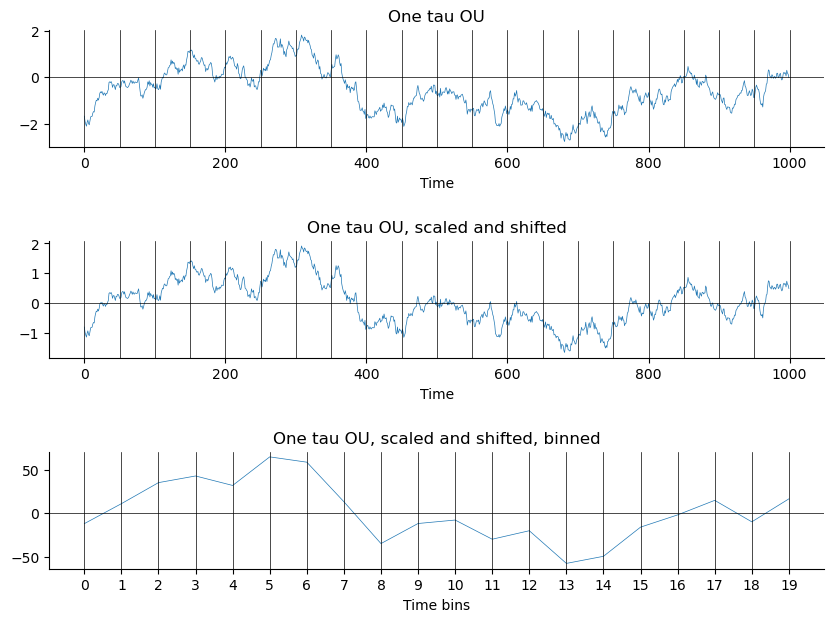

In [7]:
fig, axes = plt.subplots(3,1, figsize=(10,7))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

axes[0].plot(np.linspace(0,ou.shape[1]-1,ou.shape[1]), ou[0], lw=0.5)
axes[0].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[0].axvline(x=50*i, color='k', lw=0.5)
axes[0].set_xlabel('Time')
axes[0].set_title('One tau OU')

axes[1].plot(np.linspace(0,ou.shape[1]-1,ou.shape[1]), ou_all[0], lw=0.5)
axes[1].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[1].axvline(x=50*i, color='k', lw=0.5)
axes[1].set_xlabel('Time')
axes[1].set_title('One tau OU, scaled and shifted')

# that is supposed to be binned rate but it goes negative? is it ok?
axes[2].plot(np.linspace(0,numBinData-1,numBinData), ou_binned_data[0], lw=0.5)
axes[2].axhline(y=0, color='k', lw=0.5)
axes[2].set_xticks(np.linspace(0,numBinData-1,numBinData))
for i in range(numBinData):
    axes[2].axvline(x=i, color='k', lw=0.5)
axes[2].set_xlabel('Time bins')
axes[2].set_title('One tau OU, scaled and shifted, binned')

sns.despine()

In [8]:
# calculate ACF 

# Using ABC
summStat_metric = 'comp_cc'
ifNorm = True # if normalize the autocorrelation or PSD
ou_all_data_sumStat, ou_all_data_mean, ou_all_data_var, ou_all_T, ou_all_numTrials =  abcTau.preprocessing.extract_stats(ou_all, deltaT, binSize,
                                                                                  summStat_metric, ifNorm, maxTimeLag)
print('ou_all_data_mean: {}, ou_all_data_var: {}, ou_all_T: {}, ou_all_numTrials: {}, \n ou_all_data_sumStat: {}'.format(ou_all_data_mean, 
                                                                                                                         ou_all_data_var, 
                                                                                                                         ou_all_T, 
                                                                                                                         ou_all_numTrials, 
                                                                                                                         ou_all_data_sumStat))

# Using acf func
ou_all_acf = acf(ou_binned_data[0], nlags=num_lags)
print('ou_all_acf: {}'.format(ou_all_acf))

ou_all_data_mean: 1.9657090792431653, ou_all_data_var: 1075.2980712422445, ou_all_T: 1000, ou_all_numTrials: 1, 
 ou_all_data_sumStat: [ 1.          0.74123548  0.46398157  0.27595345  0.1125388  -0.10368666
 -0.32447041 -0.36190806 -0.50442727 -0.45681915 -0.24083186 -0.0918918
  0.17689441  0.49899983  0.47716794  0.13387953  0.03937031  0.01582032
  0.14127049  0.        ]
ou_all_acf: [ 1.          0.70367653  0.41754822  0.23579841  0.0924655  -0.07957593
 -0.25811512 -0.32712261 -0.42705965 -0.39143978 -0.27189715 -0.21269373
 -0.11584717  0.00401125  0.07085011  0.02803707  0.01761189  0.00938826
  0.01381034 -0.00944643]


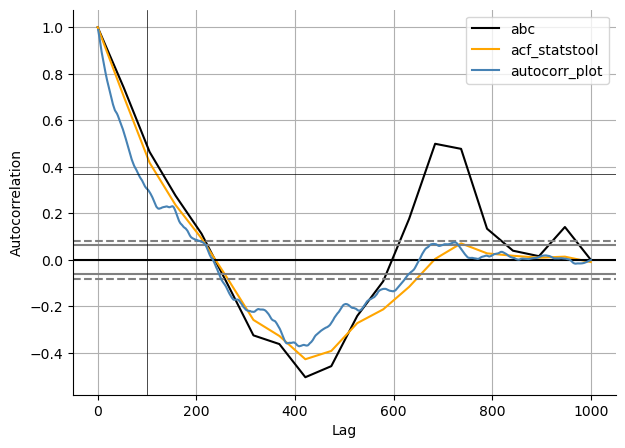

In [9]:
t_axis_lags = np.linspace(0, num_lags*binSize, num_lags)

fig, axes = plt.subplots(1,1, figsize=(7,5))

axes.plot(t_axis_lags, ou_all_data_sumStat, c='k', label='abc')
axes.plot(t_axis_lags, ou_all_acf, c='orange', label='acf_statstool')
pd.plotting.autocorrelation_plot(ou_all[0,:], ax=axes, c='steelblue', label='autocorr_plot')
#pd.plotting.autocorrelation_plot(ou[0,:], ax=axes, c='darkblue', label='autocorr_plot')
axes.axvline(x=100, lw=0.5, color='k')
axes.axhline(y=1/np.e, lw=0.5, color='k')

sns.despine()

In [10]:
# calculate tau

# Using abc but not bayesian
ou_all_abc_popt, ou_all_abc_poptcov = abcTau.preprocessing.fit_oneTauExponential(ou_all_data_sumStat, binSize, maxTimeLag)
print(ou_all_abc_popt)

# Using curve_fit
ou_all_popt, ou_all_pcov = curve_fit(func_exp, np.linspace(0,20,20), ou_all_acf[0:], maxfev=5000)
print(ou_all_popt)
ou_all_tau = 1 / ou_all_popt[1]
ou_all_tau_ms = ou_all_tau * binSize
print(ou_all_tau, ou_all_tau_ms)

[1. 1.]
[ 1.21838531  0.46818129 -0.13155624]
2.1359247617856383 106.79623808928191


C:\Users\ipochino\.conda\envs\isttc\Lib\site-packages\abcTau\preprocessing.py:451: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(single_exp, xdata, ydata, maxfev = 2000)


In [11]:
# # using Bayesian 
# # select generative model and distance function
# generativeModel = 'oneTauOU'
# distFunc = 'linear_distance'

# # Define a uniform prior distribution over the given range
# # for a uniform prior: stats.uniform(loc=x_min,scale=x_max-x_min)
# t_min = 0.0 # first timescale
# t_max = 100.0
# priorDist = [stats.uniform(loc= t_min, scale = t_max - t_min)]

# # set fitting params
# epsilon_0 = 1  # initial error threshold
# min_samples = 100 # min samples from the posterior
# steps = 60 # max number of iterations
# minAccRate = 0.01 # minimum acceptance rate to stop the iterations
# parallel = False # if parallel processing
# n_procs = 1 # number of processor for parallel processing (set to 1 if there is no parallel processing)


# # creating model object
# class MyModel(abcTau.Model):

#     #This method initializes the model object.  
#     def __init__(self):
#         pass

#     # draw samples from the prior. 
#     def draw_theta(self):
#         theta = []
#         for p in self.prior:
#             theta.append(p.rvs())
#         return theta

#     # Choose the generative model (from generative_models)
#     # Choose autocorrelation computation method (from basic_functions)
#     def generate_data(self, theta):
#         # generate synthetic data
#         if disp == None:
#             syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
#                                          '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
#         else:
#             syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
#                                          '(theta, deltaT, binSize, T, numTrials, data_mean, data_var, disp)')
               
#         # compute the summary statistics
#         syn_sumStat = abcTau.summary_stats.comp_sumStat(syn_data, summStat_metric, ifNorm, deltaT, binSize, T,\
#                                           numBinData, maxTimeLag)   
#         return syn_sumStat

#     # Computes the summary statistics
#     def summary_stats(self, data):
#         sum_stat = data
#         return sum_stat

#     # Choose the method for computing distance (from basic_functions)
#     def distance_function(self, data, synth_data):
#         if np.nansum(synth_data) <= 0: # in case of all nans return large d to reject the sample
#             d = 10**4
#         else:
#             d = eval('abcTau.distance_functions.' +distFunc + '(data, synth_data)')        
#         return d

# # path for loading and saving data
# datasave_path = 'Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\'
# inter_save_direc = datasave_path
# inter_filename = 'inter_filename'
# filename = 'test_1_trial'
# filenameSave = filename
# disp = None

# # fit with aABC algorithm for any generative model
# abc_results, final_step = abcTau.fit.fit_withABC(MyModel, ou_all_data_sumStat, priorDist, inter_save_direc, inter_filename,\
#                                                  datasave_path,filenameSave, epsilon_0, min_samples, \
#                                                  steps, minAccRate, parallel, n_procs, disp)

# # extract estimated parameters
# theta_accepted = abc_results[final_step-1]['theta accepted']
# ou_all_bay_tau = theta_accepted[0]

# print('B tau mean {}, B tau median {}'.format(np.mean(ou_all_bay_tau), np.median(ou_all_bay_tau)))
# plt.hist(ou_all_bay_tau, density=True, label = r'Estimated')

In [12]:
# # generate OU
# numBin = int(T/deltaT)
# print('numBin:', numBin)

# noise =  np.random.normal(loc=0,scale=1, size=(numTrials,numBin))
# print('noise.shape: ', noise.shape)

# noise_ou = np.sqrt(2*D*deltaT) * noise
# print('noise_ou.shape: ', noise_ou.shape)

# ou = np.zeros((numTrials,numBin))
# ou[:,0] = noise[:,0]
# for iBin in range(1,numBin):
#     ou[:,iBin]  = ou[:,iBin-1] - (ou[:,iBin-1]/tau) * deltaT + np.sqrt(2*D*deltaT) * noise[:,iBin-1]

# print('ou.shape: ', ou.shape)

# # adjust OU process - scale, shift and rectify (to get time-varying rate)

# data_mean = 1 # average of firing rate
# data_var = 1.5 # variance of firing rate

# ou_check = np.max(ou)
# print(ou_check)

# ou_std = np.sqrt(data_var)
# ou_mean = data_mean
# ou_all = ou_std * ou + ou_mean # this is scale and shift, where is rectify?

# print('ou_all.shape: ', ou_all.shape)

# Plot all steps
# fig, axes = plt.subplots(5,1, figsize=(10,8))

# axes[0].plot(np.linspace(0,numBin-1,numBin), noise[0], lw=0.5)
# axes[0].axhline(y=0, color='k', lw=0.5)

# axes[1].plot(np.linspace(0,numBin-1,numBin), noise_ou[0], lw=0.5)
# axes[1].axhline(y=0, color='k', lw=0.5)

# axes[2].plot(np.linspace(0,numBin-1,numBin), ou[0], lw=0.5)
# axes[2].axhline(y=0, color='k', lw=0.5)

# axes[3].plot(np.linspace(0,numBin-1,numBin), ou_all[0], lw=0.5)
# axes[3].axhline(y=0, color='k', lw=0.5)
# for i in range(numBinData+1):
#     axes[3].axvline(x=50*i, color='k', lw=0.5)

# # that is supposed to be binned rate but it goes negative? is it ok?
# axes[4].plot(np.linspace(0,numBinData-1,numBinData), binned_data[0], lw=0.5)
# axes[4].axhline(y=0, color='k', lw=0.5)
# axes[4].set_xticks(np.linspace(0,numBinData-1,numBinData))

# sns.despine()

In [13]:
# np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_data\\ou_tau100ms_1trials_1000ms.npy', ou)
# np.save('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_data\\ou_all_tau100ms_1trials_1000ms.npy', ou_all)

#### One tau UO with Poisson spike count

In [14]:
ou_std =  np.sqrt(data_var - data_mean)/deltaT # law of total variance  
ou_mean = data_mean/deltaT # law of total expectation

# fit mean and var
ou_poisson = ou_std * ou + ou_mean
ou_poisson[ou_poisson < 0] = 0 # rectifying

# bin rate and generate spikes
numBin = int(T/deltaT)
ou_poisson_rate_ = abcTau.binData(ou_poisson, [numTrials,numBin]) * deltaT
ou_poisson_rate = np.random.poisson(ou_poisson_rate_)

# bin for ACF calculation
ou_poisson_binned = abcTau.binData(ou_poisson_rate, [numTrials, numBinData]) * deltaT
print(ou_poisson_binned.shape)

(1, 20)


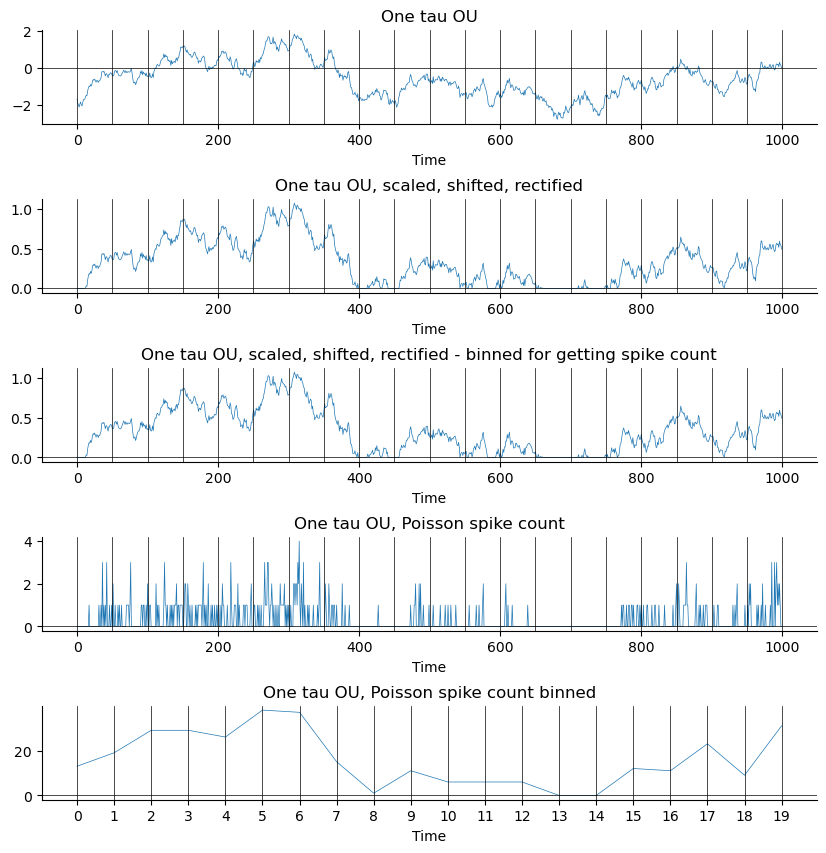

In [15]:
fig, axes = plt.subplots(5,1, figsize=(10,10))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

axes[0].plot(np.linspace(0,numBin-1,numBin), ou[0], lw=0.5)
axes[0].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[0].axvline(x=50*i, color='k', lw=0.5)
axes[0].set_title('One tau OU')

axes[1].plot(np.linspace(0,numBin-1,numBin), ou_poisson[0], lw=0.5)
axes[1].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[1].axvline(x=50*i, color='k', lw=0.5)
axes[1].set_title('One tau OU, scaled, shifted, rectified')

axes[2].plot(np.linspace(0,numBin-1,numBin), ou_poisson_rate_[0], lw=0.5)
axes[2].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[2].axvline(x=50*i, color='k', lw=0.5)
axes[2].set_title('One tau OU, scaled, shifted, rectified - binned for getting spike count')

axes[3].plot(np.linspace(0,numBin-1,numBin), ou_poisson_rate[0], lw=0.5)
axes[3].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[3].axvline(x=50*i, color='k', lw=0.5)
axes[3].set_title('One tau OU, Poisson spike count')
# for i in range(numBinData+1):
#     axes[3].axvline(x=50*i, color='k', lw=0.5)

# that is supposed to be binned rate but it goes negative? is it ok?
axes[4].plot(np.linspace(0,numBinData-1,numBinData), ou_poisson_binned[0], lw=0.5)
axes[4].axhline(y=0, color='k', lw=0.5)
axes[4].set_xticks(np.linspace(0,numBinData-1,numBinData))
for i in range(numBinData):
    axes[4].axvline(x=i, color='k', lw=0.5)
axes[4].set_title('One tau OU, Poisson spike count binned')


for ax in axes.flat:
    ax.set_xlabel('Time')

sns.despine()

In [16]:
# calculate ACF 

# Using ABC
summStat_metric = 'comp_cc'
ifNorm = True # if normalize the autocorrelation or PSD
ou_poisson_data_sumStat, ou_poisson_data_mean, ou_poisson_data_var, ou_poisson_T, ou_poisson_numTrials =  abcTau.preprocessing.extract_stats(ou_poisson_rate, 
                                                                                                                         deltaT, binSize,
                                                                                  summStat_metric, ifNorm, maxTimeLag)
print('ou_poisson_data_mean: {}, ou_poisson_data_var: {}, ou_poisson_T: {}, ou_poisson_numTrials: {}, \n ou_poisson_data_sumStat: {}'.format(ou_poisson_data_mean, 
                                                                                                                         ou_poisson_data_var, 
                                                                                                                         ou_poisson_T, 
                                                                                                                         ou_poisson_numTrials, 
                                                                                                                         ou_poisson_data_sumStat))

# Using acf func
ou_poisson_acf = acf(ou_poisson_binned[0], nlags=num_lags)
print('ou_poisson_acf: {}'.format(ou_poisson_acf))

ou_poisson_data_mean: 16.1, ou_poisson_data_var: 140.39, ou_poisson_T: 1000, ou_poisson_numTrials: 1, 
 ou_poisson_data_sumStat: [ 1.          0.61648605  0.46325976  0.24619997  0.10862597 -0.22701839
 -0.36734403 -0.42527347 -0.48278209 -0.53087061 -0.24446186 -0.24930551
  0.01335565  0.41458852  0.49702812  0.14787378  0.13355652  0.20894176
  0.23505948  0.        ]
ou_poisson_acf: [ 1.          0.58479593  0.41690291  0.21318114  0.09237125 -0.16562789
 -0.27261913 -0.33370254 -0.37398675 -0.38627751 -0.2379443  -0.22744141
 -0.12113398  0.03873851  0.11299238  0.05087613  0.0485932   0.05350452
  0.02322815 -0.0164506 ]


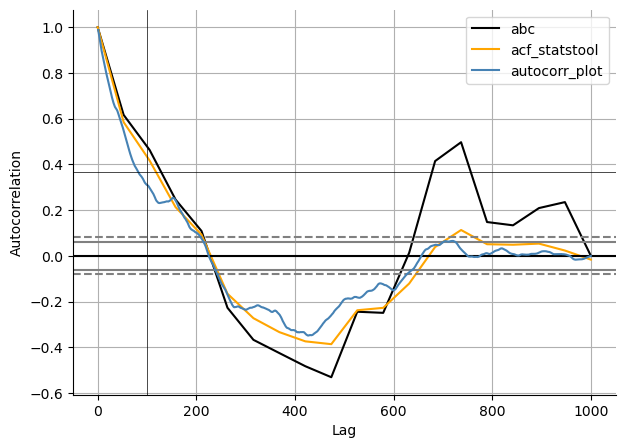

In [17]:
t_axis_lags = np.linspace(0, 1000, 20)

fig, axes = plt.subplots(1,1, figsize=(7,5))

axes.plot(t_axis_lags, ou_poisson_data_sumStat, c='k', label='abc')
axes.plot(t_axis_lags, ou_poisson_acf, c='orange', label='acf_statstool')
pd.plotting.autocorrelation_plot(ou_poisson[0,:], ax=axes, c='steelblue', label='autocorr_plot')
#pd.plotting.autocorrelation_plot(ou[0,:], ax=axes, c='darkblue', label='autocorr_plot')
axes.axvline(x=100, lw=0.5, color='k')
axes.axhline(y=1/np.e, lw=0.5, color='k')

sns.despine()

In [18]:
# calculate tau

# Using abc but not bayesian
ou_poisson_abc_popt, ou_poisson_abc_poptcov = abcTau.preprocessing.fit_oneTauExponential(ou_poisson_data_sumStat, binSize, maxTimeLag)
print(ou_poisson_abc_popt)

# Using curve_fit
ou_poisson_popt, ou_poisson_pcov = curve_fit(func_exp, np.linspace(0,20,20), ou_poisson_acf[0:], maxfev=5000)
print(ou_poisson_popt)
ou_poisson_tau = 1 / ou_poisson_popt[1]
ou_poisson_tau_ms = ou_poisson_tau * binSize
print(ou_poisson_tau, ou_poisson_tau_ms)

[1. 1.]
[ 1.16846841  0.50779841 -0.11609836]
1.9692854197435021 98.46427098717511


#### Going from rate to spikes

In [19]:
spikeTrain = np.zeros(ou_poisson_rate.shape)
print(spikeTrain.shape)

for i in range(ou_poisson_rate.shape[0]):
    spikeTrain[i,:] = [1 if ou_poisson_rate[i,j] > np.random.random() else 0 for j in range(ou_poisson_rate.shape[1])]

spike_times = np.where(np.squeeze(spikeTrain) == 1)[0]
print('N spikes {}'.format(spike_times.shape))

# bin for ACF calculation
ou_spiketrain_binned = abcTau.binData(spikeTrain, [numTrials, numBinData]) * deltaT
print(ou_spiketrain_binned.shape)

(1, 1000)
N spikes (249,)
(1, 20)


In [20]:
# fig, axes = plt.subplots(1,1, figsize=(20,4))
# sns.heatmap(ax=axes, data=spikeTrain[:,:]) 

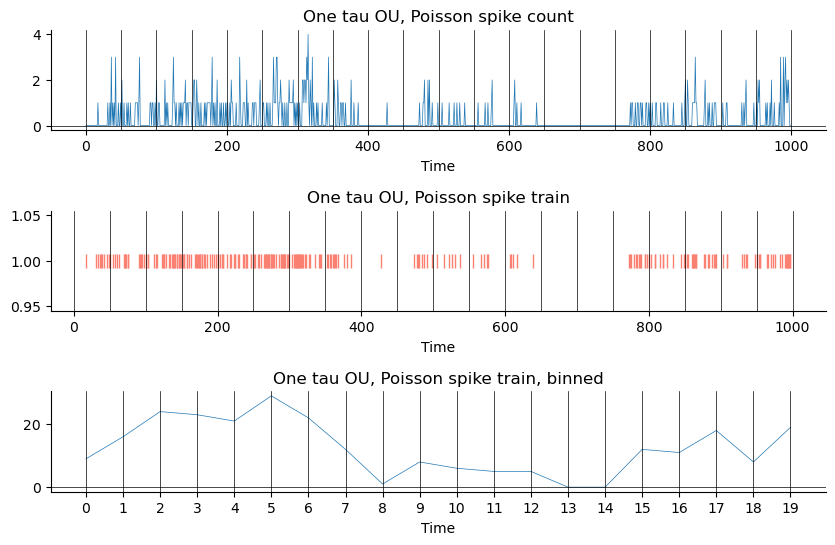

In [21]:
fig, axes = plt.subplots(3,1, figsize=(10,6))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

axes[0].plot(np.linspace(0,numBin-1,numBin), ou_poisson_rate[0], lw=0.5)
axes[0].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[0].axvline(x=50*i, color='k', lw=0.5)
axes[0].set_title('One tau OU, Poisson spike count')

axes[1].plot(spike_times, np.ones_like(spike_times), '|', markersize=10, c='salmon')  # Plot spikes as a row,
for i in range(numBinData+1):
    axes[1].axvline(x=50*i, color='k', lw=0.5)
axes[1].set_title('One tau OU, Poisson spike train')

axes[2].plot(np.linspace(0,numBinData-1,numBinData), ou_spiketrain_binned[0], lw=0.5)
axes[2].axhline(y=0, color='k', lw=0.5)
axes[2].set_xticks(np.linspace(0,numBinData-1,numBinData))
for i in range(numBinData):
    axes[2].axvline(x=i, color='k', lw=0.5)
axes[2].set_title('One tau OU, Poisson spike train, binned')

for ax in axes.flat:
    ax.set_xlabel('Time')

sns.despine()

In [22]:
# calculate ACF 

# Using ABC
summStat_metric = 'comp_cc'
ifNorm = True # if normalize the autocorrelation or PSD
spikeTrain_data_sumStat, spikeTrain_data_mean, spikeTrain_data_var, spikeTrain_T, spikeTrain_numTrials =  abcTau.preprocessing.extract_stats(spikeTrain, 
                                                                                                                         deltaT, binSize,
                                                                                  summStat_metric, ifNorm, maxTimeLag)
print('spikeTrain_data_mean: {}, spikeTrain_data_var: {}, spikeTrain_T: {}, spikeTrain_numTrials: {}, \n spikeTrain_data_sumStat: {}'.format(spikeTrain_data_mean, 
                                                                                                                         spikeTrain_data_var, 
                                                                                                                         spikeTrain_T, 
                                                                                                                         spikeTrain_numTrials, 
                                                                                                                         spikeTrain_data_sumStat))

# Using acf func
spikeTrain_acf = acf(ou_spiketrain_binned[0], nlags=num_lags)
print('ou_poisson_acf: {}'.format(spikeTrain_acf))

# Using sttc
acf_sttc = calculate_acf_isttc(spike_times, num_lags, binSize)
print('acf_sttc: {}'.format(acf_sttc))

spikeTrain_data_mean: 12.45, spikeTrain_data_var: 70.84750000000003, spikeTrain_T: 1000, spikeTrain_numTrials: 1, 
 spikeTrain_data_sumStat: [ 1.          0.68177337  0.50369011  0.23580059  0.10139516 -0.21586271
 -0.37397082 -0.4505051  -0.49519508 -0.55841044 -0.23430608 -0.24099755
  0.09615724  0.34307664  0.48539312  0.0965454   0.02822965  0.05175436
  0.27171036  0.        ]
ou_poisson_acf: [ 1.          0.64684534  0.45332933  0.20413035  0.08718727 -0.15357811
 -0.27775504 -0.3519302  -0.38534881 -0.40532305 -0.23291224 -0.22846784
 -0.09388475  0.01031617  0.10834186  0.04909312  0.02993048  0.02872896
  0.02724514 -0.01594799]
acf_sttc: [1.         0.78482297 0.12299757 0.11856586 0.21695433 0.37094796
 0.16806723 0.4328761  0.29891304 0.38789933 0.45416812 0.38660651
 0.54266827 0.6747076  0.89829606 1.         1.         1.
 1.         1.                nan]


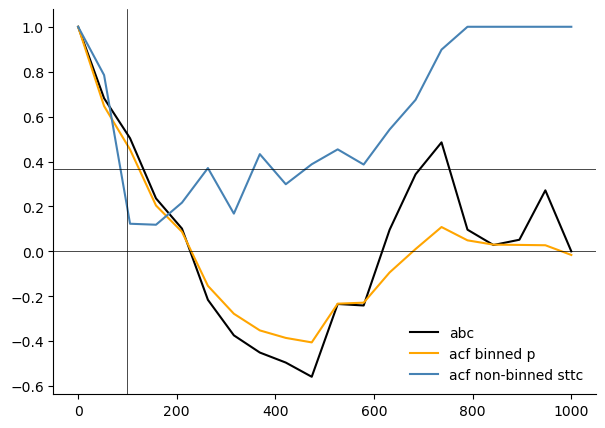

In [28]:
t_axis_lags = np.linspace(0, 1000, 20)

fig, axes = plt.subplots(1,1, figsize=(7,5))

axes.plot(t_axis_lags, spikeTrain_data_sumStat, c='k', label='abc')
axes.plot(t_axis_lags, spikeTrain_acf, c='orange', label='acf binned p')
axes.plot(t_axis_lags, acf_sttc[:-1], c='steelblue', label='acf non-binned sttc')

axes.axvline(x=100, lw=0.5, color='k')
axes.axhline(y=1/np.e, lw=0.5, color='k')
axes.axhline(y=0, lw=0.5, c='k')

axes.legend(frameon=False)

#axes.set_xlim([0,500])

sns.despine()

In [24]:
acf_sttc

array([1.        , 0.78482297, 0.12299757, 0.11856586, 0.21695433,
       0.37094796, 0.16806723, 0.4328761 , 0.29891304, 0.38789933,
       0.45416812, 0.38660651, 0.54266827, 0.6747076 , 0.89829606,
       1.        , 1.        , 1.        , 1.        , 1.        ,
              nan])

In [25]:
# calculate tau

# Using abc but not bayesian
ou_spiketrain_abc_popt, ou_spiketrain_abc_poptcov = abcTau.preprocessing.fit_oneTauExponential(spikeTrain_data_sumStat, binSize, maxTimeLag)
print(ou_spiketrain_abc_popt)

# Using curve_fit
ou_spiketrain_popt, _ = curve_fit(func_exp, np.linspace(0,20,20), spikeTrain_acf[0:], maxfev=5000)
print(ou_spiketrain_popt)
ou_spiketrain_tau = 1 / ou_spiketrain_popt[1]
ou_spiketrain_tau_ms = ou_spiketrain_tau * binSize
print(ou_spiketrain_tau, ou_spiketrain_tau_ms)

# # curvefit and sttc
# ou_spiketrain1_popt, _ = curve_fit(func_exp, np.linspace(0,10,10), acf_sttc[0:10], maxfev=5000)
# print(ou_spiketrain1_popt)
# ou_spiketrain1_tau = 1 / ou_spiketrain1_popt[1]
# ou_spiketrain1_tau_ms = ou_spiketrain1_tau * binSize
# print(ou_spiketrain1_tau, ou_spiketrain1_tau_ms)

[1. 1.]
[ 1.19938932  0.4904293  -0.12371392]
2.0390298800947155 101.95149400473578


### Schematic of data generation

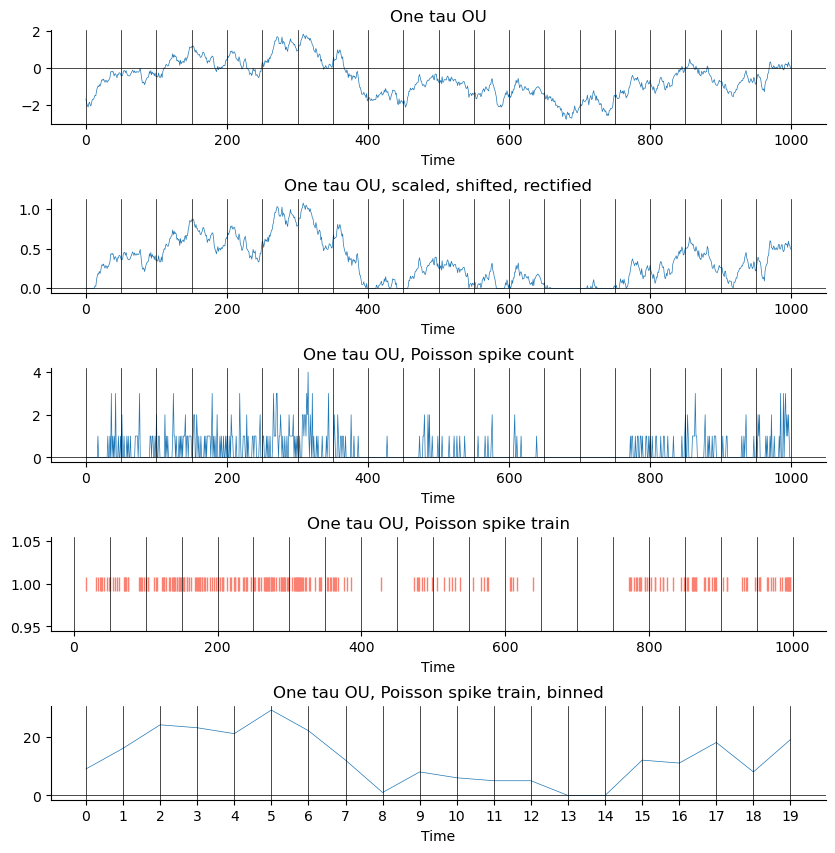

In [27]:
# plot
fig, axes = plt.subplots(5,1, figsize=(10,10))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

axes[0].plot(np.linspace(0,numBin-1,numBin), ou[0], lw=0.5)
axes[0].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[0].axvline(x=50*i, color='k', lw=0.5)
axes[0].set_title('One tau OU')

axes[1].plot(np.linspace(0,numBin-1,numBin), ou_poisson[0], lw=0.5)
axes[1].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[1].axvline(x=50*i, color='k', lw=0.5)
axes[1].set_title('One tau OU, scaled, shifted, rectified')

axes[2].plot(np.linspace(0,numBin-1,numBin), ou_poisson_rate[0], lw=0.5)
axes[2].axhline(y=0, color='k', lw=0.5)
for i in range(numBinData+1):
    axes[2].axvline(x=50*i, color='k', lw=0.5)
axes[2].set_title('One tau OU, Poisson spike count')

axes[3].plot(spike_times, np.ones_like(spike_times), '|', markersize=10, c='salmon')  # Plot spikes as a row,
for i in range(numBinData+1):
    axes[3].axvline(x=50*i, color='k', lw=0.5)
axes[3].set_title('One tau OU, Poisson spike train')

axes[4].plot(np.linspace(0,numBinData-1,numBinData), ou_spiketrain_binned[0], lw=0.5)
axes[4].axhline(y=0, color='k', lw=0.5)
axes[4].set_xticks(np.linspace(0,numBinData-1,numBinData))
for i in range(numBinData):
    axes[4].axvline(x=i, color='k', lw=0.5)
axes[4].set_title('One tau OU, Poisson spike train, binned')

for ax in axes.flat:
    ax.set_xlabel('Time')

sns.despine()

#fig.savefig('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\' + 'data_generation_schematic.png' , bbox_inches='tight')